<a href="https://colab.research.google.com/github/Tilakraj-B/cardiac-disease/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from google.colab import drive
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = "/content/drive/MyDrive/acdc_dataset.zip"  # Update this path
extract_folder = "/content/acdc_data"

In [4]:
# Step 3: Extract the dataset if not already extracted
if not os.path.exists(extract_folder):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_path, "r") as zip_ref:
        zip_ref.extractall(extract_folder)
    print("Extraction complete.")
else:
    print("Dataset already extracted.")


Extracting dataset...
Extraction complete.


In [5]:
def load_nii_file(filepath):
    img = nib.load(filepath)
    data = img.get_fdata()
    return data


In [6]:
# Step 5: Load and visualize a sample image (Modify the path based on extracted files)
base_dir = os.path.join(extract_folder,"database")
training_folder = os.path.join(extract_folder,"database","training")
testing_folder = os.path.join(extract_folder,"database","testing")
train_patients = [f'patient{i:03d}' for i in range(1, 100)]
test_patients = [f'patient{i:03d}' for i in range(1, 50)]

# info_file_path = os.path.join(patient_folder, "Info.cfg")

# if os.path.exists(info_file_path):
#     with open(info_file_path, "r") as file:
#         info_content = file.read()
#     print("Contents of Info.cfg:\n")
#     print(info_content)
# else:
#     print("Info.cfg not found. Check the path!")



In [7]:
# Display all the images of a patient

def display_nifti_slices(nifti_path):
    nifti_img = nib.load(nifti_path)  # Load NIfTI file
    image_data = nifti_img.get_fdata()  # Convert to NumPy array

    print(f"\nDisplaying slices for {os.path.basename(nifti_path)}")
    print(f"Image shape: {image_data.shape}")  # Print shape

    dim = image_data.ndim  # Get number of dimensions
    if dim == 2:  # Case: 2D Image
        plt.figure(figsize=(6, 6))
        plt.imshow(image_data, cmap="gray")
        plt.title(f"{os.path.basename(nifti_path)} - 2D Image")
        plt.axis("off")
        plt.show()

    elif dim == 3:  # Case: 3D Image (H, W, D)
        num_slices = image_data.shape[2]
        for i in range(num_slices):
            plt.figure(figsize=(6, 6))
            plt.imshow(image_data[:, :, i], cmap="gray")
            plt.title(f"{os.path.basename(nifti_path)} - Slice {i+1}/{num_slices}")
            plt.axis("off")
            plt.show()

    elif dim == 4:  # Case: 4D Image (H, W, D, T)
        num_slices = image_data.shape[2]
        num_timeframes = image_data.shape[3]
        for t in range(num_timeframes):  # Loop over time
            for i in range(num_slices):  # Loop over depth
                plt.figure(figsize=(6, 6))
                plt.imshow(image_data[:, :, i, t], cmap="gray")
                plt.title(f"{os.path.basename(nifti_path)} - Time {t+1}/{num_timeframes} - Slice {i+1}/{num_slices}")
                plt.axis("off")
                plt.show()

    else:
        print(f"Unsupported image dimension: {dim}")

In [8]:
# # displaying dimension and shape of the imagedatabase
# for i in range(1,100):
#   patient_folder = os.path.join(training_folder, f"patient{i:03d}")
#   for filename in sorted(os.listdir(patient_folder)):
#     if filename.endswith(".nii"):
#       nifti_path = os.path.join(patient_folder, filename)
#       # display_nifti_slices(nifti_path)
#       nifti_img = nib.load(nifti_path)  # Load NIfTI file
#       image_data = nifti_img.get_fdata()  # Convert to NumPy array
#       dim = image_data.ndim
#       # print(filename + " : " + str(dim) + " dimensions" + str(image_data.shape))


In [9]:
def load_patient_data(patient_folder):
    # Get all .nii files in the folder
    files = [f for f in os.listdir(patient_folder) if f.endswith('.nii') and not f.endswith('4d.nii')]

    # Separate image and ground truth files
    image_files = [f for f in files if not f.endswith('_gt.nii')]
    gt_files = [f for f in files if f.endswith('_gt.nii')]

    images = []
    masks = []

    for img_file, gt_file in zip(sorted(image_files), sorted(gt_files)):
        img_data = load_nii_file(os.path.join(patient_folder, img_file))
        gt_data = load_nii_file(os.path.join(patient_folder, gt_file))

        #iterating through each slice in the model
        for slice_idx in range(img_data.shape[2]):
            img_slice = img_data[..., slice_idx]
            gt_slice = gt_data[..., slice_idx]

            # Normalize and resize if needed
            img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())
            gt_slice = (gt_slice > 0).astype(np.float32)  # Binarize if needed

            # Resize to make dimensions divisible by 16 for U-Net (optional)
            img_slice = tf.image.resize(img_slice[..., np.newaxis], [224, 256])
            gt_slice = tf.image.resize(gt_slice[..., np.newaxis], [224, 256])

            images.append(img_slice.numpy())
            masks.append(gt_slice.numpy())

    return np.array(images), np.array(masks)




In [10]:
def load_dataset(root_folder, patient_range):
    all_images = []
    all_masks = []

    for patient_id in patient_range:
        patient_folder = os.path.join(root_folder, f"patient{patient_id:03d}")
        if os.path.exists(patient_folder):
            images, masks = load_patient_data(patient_folder)
            all_images.extend(images)
            all_masks.extend(masks)

    return np.array(all_images), np.array(all_masks)


In [11]:
def unet_model(input_size=(224, 256, 1)):
    inputs = Input(input_size)

    # Downsample path with fewer filters
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)

    # Upsample path
    up1 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv4))
    merge1 = concatenate([conv3, up1], axis=3)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(merge1)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(conv5)

    up2 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge2 = concatenate([conv2, up2], axis=3)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(merge2)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(conv6)

    up3 = Conv2D(32, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge3 = concatenate([conv1, up3], axis=3)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(merge3)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [12]:
def train_model():
    # Load training data
    train_images, train_masks = load_dataset(training_folder, range(1, 21))

    # Split into training and validation
    X_train, X_val, y_train, y_val = train_test_split(
        train_images, train_masks, test_size=0.2, random_state=42
    )

    # Create model
    model = unet_model()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])])

    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
    ]

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=16,
        epochs=20,
        callbacks=callbacks
    )

    return model, history

In [18]:
def evaluate_model(model):
    # Load test data
    test_images, test_masks = load_dataset(testing_folder, range(101, 151))  # Assuming test data range is 101-150

    # Evaluate
    results = model.evaluate(test_images, test_masks)
    print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}, Test IoU: {results[2]}")

    # Optionally visualize some predictions
    import matplotlib.pyplot as plt

    preds = model.predict(test_images[:5])  # Predicting on the first 5 images

    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(3, 5, i + 1)  # Corrected subplot index for input image
        plt.imshow(test_images[i].squeeze(), cmap='gray')
        plt.title('Input')
        plt.axis('off')

        plt.subplot(3, 5, i + 6)  # Corrected subplot index for ground truth
        plt.imshow(test_masks[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(3, 5, i + 11)  # Corrected subplot index for prediction
        plt.imshow(preds[i].squeeze() > 0.5, cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [16]:
    model, history = train_model()

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.7846 - io_u_2: 0.0000e+00 - loss: 0.6247

20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 570ms/step - accuracy: 0.7903 - io_u_2: 0.0000e+00 - loss: 0.6188 - val_accuracy: 0.9499 - val_io_u_2: 0.0000e+00 - val_loss: 0.2457
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9491 - io_u_2: 0.0000e+00 - loss: 0.1989

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 273ms/step - accuracy: 0.9492 - io_u_2: 0.0000e+00 - loss: 0.1977 - val_accuracy: 0.9499 - val_io_u_2: 0.0000e+00 - val_loss: 0.1545
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9508 - io_u_2: 0.0000e+00 - loss: 0.1447

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step - accuracy: 0.9508 - io_u_2: 0.0000e+00 - loss: 0.1446 - val_accuracy: 0.9499 - val_io_u_2: 0.0000e+00 - val_loss: 0.1407
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9521 - io_u_2: 0.0000e+00 - loss: 0.1328

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 278ms/step - accuracy: 0.9520 - io_u_2: 0.0000e+00 - loss: 0.1326 - val_accuracy: 0.9499 - val_io_u_2: 0.0000e+00 - val_loss: 0.1174
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - accuracy: 0.9504 - io_u_2: 0.0000e+00 - loss: 0.1235 - val_accuracy: 0.9499 - val_io_u_2: 0.0000e+00 - val_loss: 0.1415
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 271ms/step - accuracy: 0.9481 - io_u_2: 0.0000e+00 - loss: 0.1305 - val_accuracy: 0.9499 - val_io_u_2: 0.0000e+00 - val_loss: 0.1300
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9531 - io_u_2: 0.0000e+00 - loss: 0.1146

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 278ms/step - accuracy: 0.9529 - io_u_2: 0.0000e+00 - loss: 0.1145 - val_accuracy: 0.9499 - val_io_u_2: 0.0000e+00 - val_loss: 0.0958
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9546 - io_u_2: 0.0000e+00 - loss: 0.0941

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.9548 - io_u_2: 0.0000e+00 - loss: 0.0941 - val_accuracy: 0.9651 - val_io_u_2: 0.0000e+00 - val_loss: 0.0862
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9617 - io_u_2: 0.0000e+00 - loss: 0.0951

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - accuracy: 0.9617 - io_u_2: 0.0000e+00 - loss: 0.0949 - val_accuracy: 0.9692 - val_io_u_2: 0.0000e+00 - val_loss: 0.0781
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9734 - io_u_2: 0.0000e+00 - loss: 0.0698

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.9734 - io_u_2: 0.0000e+00 - loss: 0.0695 - val_accuracy: 0.9743 - val_io_u_2: 0.0000e+00 - val_loss: 0.0627
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9792 - io_u_2: 0.0000e+00 - loss: 0.0516

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step - accuracy: 0.9792 - io_u_2: 0.0000e+00 - loss: 0.0516 - val_accuracy: 0.9784 - val_io_u_2: 0.0000e+00 - val_loss: 0.0542
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 277ms/step - accuracy: 0.9795 - io_u_2: 3.8138e-05 - loss: 0.0518 - val_accuracy: 0.9787 - val_io_u_2: 0.0000e+00 - val_loss: 0.0570
Epoch 13/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9798 - io_u_2: 0.0000e+00 - loss: 0.0534

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.9798 - io_u_2: 0.0000e+00 - loss: 0.0531 - val_accuracy: 0.9819 - val_io_u_2: 0.0000e+00 - val_loss: 0.0432
Epoch 14/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 277ms/step - accuracy: 0.9838 - io_u_2: 0.0000e+00 - loss: 0.0389 - val_accuracy: 0.9808 - val_io_u_2: 0.0000e+00 - val_loss: 0.0438
Epoch 15/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9853 - io_u_2: 2.3202e-04 - loss: 0.0340

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.9853 - io_u_2: 2.4046e-04 - loss: 0.0340 - val_accuracy: 0.9847 - val_io_u_2: 0.0000e+00 - val_loss: 0.0336
Epoch 16/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9871 - io_u_2: 6.1307e-04 - loss: 0.0299

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.9871 - io_u_2: 6.4985e-04 - loss: 0.0299 - val_accuracy: 0.9867 - val_io_u_2: 0.0000e+00 - val_loss: 0.0316
Epoch 17/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.9876 - io_u_2: 8.5777e-04 - loss: 0.0292 - val_accuracy: 0.9824 - val_io_u_2: 3.7151e-04 - val_loss: 0.0402
Epoch 18/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9882 - io_u_2: 0.0024 - loss: 0.0272

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 270ms/step - accuracy: 0.9882 - io_u_2: 0.0024 - loss: 0.0272 - val_accuracy: 0.9871 - val_io_u_2: 0.0000e+00 - val_loss: 0.0294
Epoch 19/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9898 - io_u_2: 4.1160e-04 - loss: 0.0228

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - accuracy: 0.9898 - io_u_2: 4.2721e-04 - loss: 0.0227 - val_accuracy: 0.9879 - val_io_u_2: 0.0000e+00 - val_loss: 0.0264
Epoch 20/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9916 - io_u_2: 0.0020 - loss: 0.0187

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.9915 - io_u_2: 0.0021 - loss: 0.0187 - val_accuracy: 0.9892 - val_io_u_2: 0.0000e+00 - val_loss: 0.0231


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9813 - io_u_2: 0.0000e+00 - loss: 0.0542
Test Loss: 0.055572956800460815, Test Accuracy: 0.9804075956344604, Test IoU: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


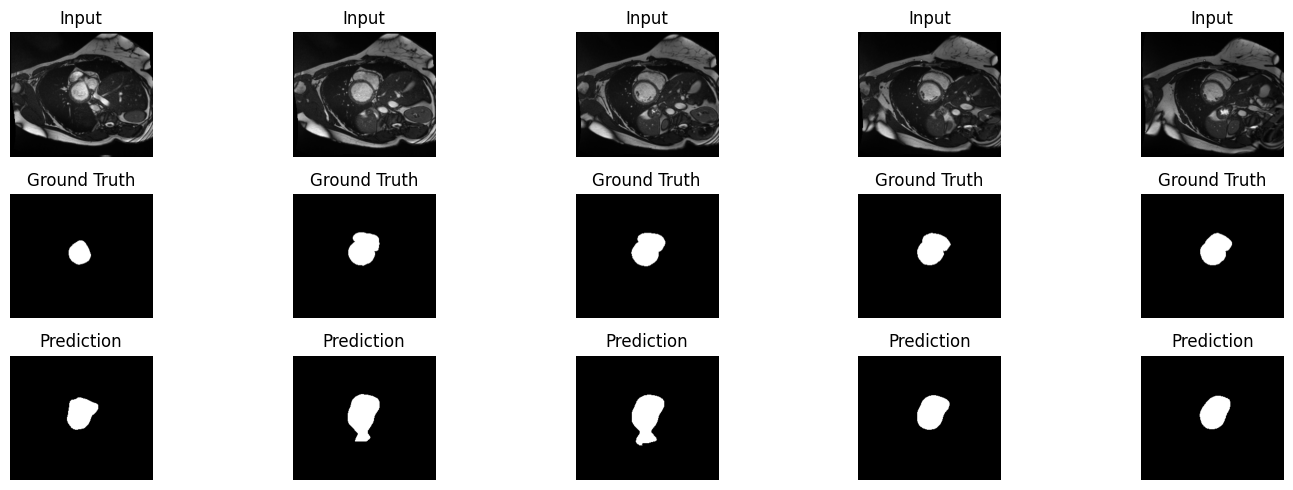

In [19]:
    # Evaluate on test set
    evaluate_model(model)

    # Optionally save the model
    model.save('unet_mri_segmentation.keras')